# Kundur Two Areas

## Run simulation

### Import Libraries

In [1]:
import sys
sys.path.insert(0,'/home/mmo/git/pscc/dpsim/python/src/dpsim')
sys.path.insert(0,'/home/mmo/git/pscc/dpsim/build')
sys.path.remove('/home/mmo/git/lund-anm-control')

import matpower
import dpsimpy

from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt

%matplotlib widget

print(dpsimpy.__file__)

/home/mmo/git/pscc/dpsim/build/dpsimpy.cpython-39-x86_64-linux-gnu.so


### Simulation parameters

In [2]:
# simulation files
path_static_file =  '/home/mmo/git/pscc/dpsim/examples/Notebooks/MatDyn/Kundur2Areas/Kundur2Areas_paper.mat'
path_dynamic_file = '/home/mmo/git/pscc/dpsim/examples/Notebooks/MatDyn/Kundur2Areas/Kundur2Areas_dyn_paper.mat'

with_snubber = True

### 1. Powerflow for initialization

In [3]:
sim_name_pf = 'Kundur2Areas_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader = matpower.Reader(mpc_file_path=path_static_file, mpc_name='Kundur2Areas',
                             mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='Kundur2Areas_dyn')

# create dpsim objects
mpc_reader.create_dpsim_objects(domain=matpower.Domain.PF, frequency=60, with_avr=False, with_tg=False, with_pss=False)

if with_snubber:
    ### Add snubbers to each SG
    for gen_name in ["Gen_N1", "Gen_N3", "Gen_N4"]:               
        #add snubber res
        snubber = dpsimpy.sp.ph1.ShuntSeries('SnubberRes_{}'.format(gen_name), dpsimpy.LogLevel.info)
        snubber.set_parameters(R=3.96035, C=6.6978653e-5)
        snubber.set_base_voltage(20000)
        mpc_reader.dpsimpy_comp_dict['Snubber_{}'.format(gen_name)] = []
        mpc_reader.dpsimpy_comp_dict['Snubber_{}'.format(gen_name)].append(snubber)
        mpc_reader.dpsimpy_comp_dict['Snubber_{}'.format(gen_name)].append(mpc_reader.dpsimpy_comp_dict[gen_name][1])

# create dpsim topology
mpc_reader.create_dpsim_topology()
system_pf = mpc_reader.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

[18:47:52.034855 Kundur2Areas_PF info] Initialize simulation: Kundur2Areas_PF
[18:47:52.035256 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N5
[18:47:52.035263 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N6
[18:47:52.035266 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[18:47:52.035269 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N8
[18:47:52.035272 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[18:47:52.035275 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N10
[18:47:52.035278 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N11
[18:47:52.035497 Kundur2Areas_PF info] Scheduling tasks.
[18:47:52.035671 Kundur2Areas_PF info] Scheduling done.
[18:47:52.035674 Kundur2Areas_PF info] Opening interfaces.
[18:47:52.035675 Kundur2Areas_PF info] Start synchronization with remotes on interfaces
[18:47:52.035676 Kundur2Areas_PF info] Synchronized simulation st

### 2. Dynamic simulation with Inverter (steady state)

#### Inverter parameters

In [4]:
# Inverter parameters
omega = 2*np.pi*60
Vdref = 20e3*1.01
Vqref = 0
Pref=700e6

# Controller parameters
#KpVoltageCtrl = 0.210420000000000
KpVoltageCtrl = 0.1382 #4.6 --> das ist unserer Fall!
#KiVoltageCtrl = 98.414400000000000
KiVoltageCtrl = 59.2391 #4.6 --> das ist unserer Fall!
KpCurrCtrl = 5.158400000000000
KiCurrCtrl = 90.424600000000000

# VSO/PLL controller parameters
# OmegaCutoff is the cutoff-frequency of the PLL filter
# in case of VCO-mode use KpPLL=0, KiPLL=0 and OmegaCutoff = OmegaNull to work as VCO
KpPLL=0
KiPLL=0 
OmegaCutoff = 2*np.pi*60

# VSI filter parameters
Lf = 0.0051
Rf = 0.1
Cf = 2.9842e-4
Rc = 1e-12

# Droop control parameters
m_p=1.2566e-08
tau_p=1.5
tau_l=0.001

#### Dynamic Simulation

In [5]:
def Kundur2Areas_Fault(domain="DP", with_inverter1=True, with_inverter2=True, with_fault=False, with_droop_control = False, log_initial_conditions=False):
    
    sim_name_dyn = domain + "_Kundur2Areas_Fault"
    if with_inverter1:
        sim_name_dyn = sim_name_dyn + "_1Inverter"
    if with_inverter2:
        sim_name_dyn = sim_name_dyn + "_2Inverters"
    dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn)

    mpc_reader2 = matpower.Reader(mpc_file_path=path_static_file, mpc_name='Kundur2Areas',
                                  mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='Kundur2Areas_dyn')

    if domain=="SP":    
        mpc_reader2.create_dpsim_objects(domain=matpower.Domain.SP, frequency=60, 
                                with_avr=False, with_tg=False, with_pss=False)
    if domain=="DP":    
        mpc_reader2.create_dpsim_objects(domain=matpower.Domain.DP, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)
    if domain=="EMT":
        mpc_reader2.create_dpsim_objects(domain=matpower.Domain.EMT, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)        
            
    # list of generators
    inverter_list = []
    gen_list = ['Gen_N1', 'Gen_N2', 'Gen_N3', 'Gen_N4']
    
    ### Replace Gen2 by Inverter
    inverter1=None
    if with_inverter1:
        if domain=="SP":    
            inverter1=dpsimpy.sp.ph1.VSIVoltageControlDQ('Gen_N2', 'Gen_N2', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        if domain=="DP":    
            inverter1=dpsimpy.dp.ph1.VSIVoltageControlDQ('Gen_N2', 'Gen_N2', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        if domain=="EMT":    
            inverter1=dpsimpy.emt.ph3.VSIVoltageControlDQ('Gen_N2', 'Gen_N2', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        
        inverter1.set_parameters(sys_omega=omega, vd_ref=Vdref, vq_ref=Vqref, p_ref=Pref)
        inverter1.set_controller_parameters(Kp_voltage_ctrl=KpVoltageCtrl, Ki_voltage_ctrl=KiVoltageCtrl,
                                           Kp_curr_ctrl=KpCurrCtrl, Ki_curr_ctrl=KiCurrCtrl, Lf=Lf, Cf=Cf, omega_cutoff=OmegaCutoff)
        inverter1.set_droop_parameters(m_p=m_p, tau_p=tau_p, tau_l=tau_l)
        inverter1.set_filter_parameters(Lf=Lf, Cf=Cf, Rf=Rf, Rc=Rc)
        inverter1.with_control(True)
        mpc_reader2.dpsimpy_comp_dict["Gen_N2"][0] = inverter1
        inverter_list.append(inverter1)
        gen_list.remove('Gen_N2')
    
    ### Replace Gen2 by Inverter
    inverter2=None  
    if with_inverter2:
        ### Replace Gen4 by Inverter
        if domain=="SP":    
            inverter2=dpsimpy.sp.ph1.VSIVoltageControlDQ('Gen_N4', 'Gen_N4', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        elif domain=="DP":    
            inverter2=dpsimpy.dp.ph1.VSIVoltageControlDQ('Gen_N4', 'Gen_N4', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        else:
            inverter2=dpsimpy.emt.ph3.VSIVoltageControlDQ('Gen_N4', 'Gen_N4', dpsimpy.LogLevel.info, with_droop_control=with_droop_control) 
        
        inverter2.set_parameters(sys_omega=omega, vd_ref=Vdref, vq_ref=Vqref, p_ref=Pref)
        inverter2.set_controller_parameters(Kp_voltage_ctrl=KpVoltageCtrl, Ki_voltage_ctrl=KiVoltageCtrl,
                                            Kp_curr_ctrl=KpCurrCtrl, Ki_curr_ctrl=KiCurrCtrl, omega_cutoff=OmegaCutoff)
        inverter2.set_droop_parameters(m_p=m_p, tau_p=tau_p, tau_l=tau_l)
        inverter2.with_droop_control(True)    
        inverter2.set_filter_parameters(Lf=Lf, Cf=Cf, Rf=Rf, Rc=Rc)
        inverter2.with_control(True)
        mpc_reader2.dpsimpy_comp_dict["Gen_N4"][0] = inverter2
        inverter_list.append(inverter2)
        gen_list.remove('Gen_N4')
        
    sw = None
    if with_fault:
        ### Extend topology with switch between node N7 and groud    
        if domain=="SP":    
            sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.off)
            sw.set_parameters(1e18, 0.1)
            sw.open()
            mpc_reader2.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader2.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader2.dpsimpy_busses_dict["N7"]])
        elif domain=="DP":    
            sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.off)
            sw.set_parameters(1e18, 0.1)
            sw.open()
            mpc_reader2.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader2.dpsimpy_comp_dict['Fault'].append([dpsimpy.dp.SimNode.gnd, mpc_reader2.dpsimpy_busses_dict["N7"]])
        else:    
            sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.off)
            sw.set_parameters(1e18, 0.1)
            sw.open()
            mpc_reader2.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader2.dpsimpy_comp_dict['Fault'].append([dpsimpy.emt.SimNode.gnd, mpc_reader2.dpsimpy_busses_dict["N7"]])

    if with_snubber:
        ### Add snubbers to each SG    
        for gen_name in ["Gen_N1", "Gen_N3", "Gen_N4"]:
            if domain=="SP":
                # create node between snubber resistor and snubber cpacitor
                snubber_node = dpsimpy.sp.SimNode('SnubberNode_{}'.format(gen_name), dpsimpy.PhaseType.Single)
                mpc_reader2.dpsimpy_busses_dict['SnubberNode_{}'.format(gen_name)] = snubber_node
        
                snubber_cap = dpsimpy.sp.ph1.Capacitor('SnubberCap_{}'.format(gen_name), dpsimpy.LogLevel.info)
                snubber_cap.set_parameters(C=6.697653e-5)
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)] = []
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)].append(snubber_cap)
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)].append([mpc_reader2.dpsimpy_comp_dict[gen_name][1][0], snubber_node])
                
                snubber_res = dpsimpy.sp.ph1.Resistor('SnubberRes_{}'.format(gen_name), dpsimpy.LogLevel.info)
                snubber_res.set_parameters(R=3.96035)
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)] = []
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)].append(snubber_res)
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)].append([snubber_node, dpsimpy.sp.SimNode.gnd])
            if domain=="DP":   
                # create node between snubber resistor and snubber cpacitor
                snubber_node = dpsimpy.dp.SimNode('SnubberNode_{}'.format(gen_name), dpsimpy.PhaseType.Single)
                mpc_reader2.dpsimpy_busses_dict['SnubberNode_{}'.format(gen_name)] = snubber_node
        
                snubber_cap = dpsimpy.dp.ph1.Capacitor('SnubberCap_{}'.format(gen_name), dpsimpy.LogLevel.info)
                snubber_cap.set_parameters(C=6.697653e-5)
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)] = []
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)].append(snubber_cap)
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)].append([mpc_reader2.dpsimpy_comp_dict[gen_name][1][0], snubber_node])
                
                snubber_res = dpsimpy.dp.ph1.Resistor('SnubberRes_{}'.format(gen_name), dpsimpy.LogLevel.info)
                snubber_res.set_parameters(R=3.96035)
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)] = []
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)].append(snubber_res)
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)].append([snubber_node, dpsimpy.dp.SimNode.gnd])
            if domain=="EMT":   
                # create node between snubber resistor and snubber cpacitor
                snubber_node = dpsimpy.emt.SimNode('SnubberNode_{}'.format(gen_name), dpsimpy.PhaseType.ABC)
                mpc_reader2.dpsimpy_busses_dict['SnubberNode_{}'.format(gen_name)] = snubber_node
        
                snubber_cap = dpsimpy.emt.ph3.Capacitor('SnubberCap_{}'.format(gen_name), dpsimpy.LogLevel.info)
                snubber_cap.set_parameters(C=dpsimpy.Math.single_phase_parameter_to_three_phase(6.697653e-5))
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)] = []
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)].append(snubber_cap)
                mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)].append([mpc_reader2.dpsimpy_comp_dict[gen_name][1][0], snubber_node])
                
                snubber_res = dpsimpy.emt.ph3.Resistor('SnubberRes_{}'.format(gen_name), dpsimpy.LogLevel.info)
                snubber_res.set_parameters(R=dpsimpy.Math.single_phase_parameter_to_three_phase(3.96035))
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)] = []
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)].append(snubber_res)
                mpc_reader2.dpsimpy_comp_dict['SnubberRes_{}'.format(gen_name)].append([snubber_node, dpsimpy.emt.SimNode.gnd])

            
    # create dpsim topology
    mpc_reader2.create_dpsim_topology()

    #initialize node voltages using pf results
    system_dyn = mpc_reader2.system
    if domain=="SP":    
        system_dyn.init_with_powerflow(systemPF=system_pf, domain=dpsimpy.Domain.SP)
    elif domain=="DP":    
        system_dyn.init_with_powerflow(systemPF=system_pf, domain=dpsimpy.Domain.DP)
    else:
        system_dyn.init_with_powerflow(systemPF=system_pf, domain=dpsimpy.Domain.EMT)

    # initialize snubber node
    gen_names = ["Gen_N1", "Gen_N3", "Gen_N4"]
    node_names = ["N1", "N3", "N4"]
    impedance = complex(3.96034, 1/(2*np.pi*60*6.6978653e-5))
    for i in range(3):
        node = system_pf.node(node_names[i])
        node_voltage = node.single_voltage()
        current = node_voltage / impedance
        snubber_voltage = current * 3.96035
        node_dyn = system_dyn.node('SnubberNode_{}'.format(gen_names[i]))
        node_dyn.set_initial_voltage(snubber_voltage)
        
    # log results
    # 
    logDownSampling = 1/5e-5
    logDownSampling=1
    logger = dpsimpy.Logger(sim_name_dyn, True, int(logDownSampling))
    
    # Log electrical power and omega of SGs
    for gen_name in gen_list:
        logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.Theta'.format(gen_name), 'Theta', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.vf'.format(gen_name), 'Ef', mpc_reader2.dpsimpy_comp_dict[gen_name][0])

        if (not log_initial_conditions):
            logger.log_attribute('{}.Delta'.format(gen_name), 'delta', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        if ((domain=="EMT") and log_initial_conditions):
            logger.log_attribute('{}.Edq_t'.format(gen_name), 'Edq0_t', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
            logger.log_attribute('{}.Edq_s'.format(gen_name), 'Edq0_s', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
            logger.log_attribute('{}.Vdq'.format(gen_name), 'Vdq0', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
            logger.log_attribute('{}.Idq'.format(gen_name), 'Idq0', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        
    # Log electrical power and droop output of Inverters
    for idx, inverter in enumerate(inverter_list):
        logger.log_attribute('Inverter{}.Pe'.format(idx+1), 'P_elec', inverter)
        logger.log_attribute('Inverter{}.w'.format(idx+1), 'Omega', inverter)
        logger.log_attribute('Inverter{}.Theta'.format(idx+1), 'Theta', inverter)
        if log_initial_conditions:
            logger.log_attribute('Inverter{}.I'.format(idx+1), 'i_intf', inverter)
            logger.log_attribute('Inverter{}.Vcd'.format(idx+1), 'Vc_d', inverter)
            logger.log_attribute('Inverter{}.Vcq'.format(idx+1), 'Vc_q', inverter)
            logger.log_attribute('Inverter{}.States'.format(idx+1), 'voltagectrl_states', inverter)
            logger.log_attribute('Inverter{}.Irc_d'.format(idx+1), 'Irc_d', inverter)
            logger.log_attribute('Inverter{}.Irc_q'.format(idx+1), 'Irc_q', inverter)
                
    # Log line currents
    for line_name in ["line1_5-6", "line2_6-7", "line3_7-8", "line4_7-8", "line5_8-9", "line6_8-9", "line7_9-10", "line8_10-11"]:
        logger.log_attribute('{}.I'.format(line_name), 'i_intf', mpc_reader2.dpsimpy_comp_dict[line_name][0])
    #if with_fault:
    #    logger.log_attribute("Switch.I", 'i_intf', sw)
    
    if log_initial_conditions:
        # Transformer currents
        for trafo_name in ["transformer1_5-1", "transformer2_6-2", "transformer3_11-3", "transformer4_10-4"]:
            logger.log_attribute('{}.I'.format(trafo_name), 'i_intf', mpc_reader2.dpsimpy_comp_dict[trafo_name][0])
            
        # Log voltage of snubber capacitors
        for gen_name in ["Gen_N1", "Gen_N3", "Gen_N4"]:
            logger.log_attribute('SnubberCap.{}'.format(gen_name), 'v_intf', mpc_reader2.dpsimpy_comp_dict['SnubberCap_{}'.format(gen_name)][0])
            
        for node in system_dyn.nodes:
            if "SnubberNode_Gen" in node.name():
                continue
            logger.log_attribute(node.name()+'.V', 'v', node)     
    else:
        # System voltages and currents
        for node_name in ["N7", "N8"]:
            logger.log_attribute(node_name+'.V', 'v', mpc_reader2.dpsimpy_busses_dict[node_name]) 
        
    # Parametrize and run simulation
    sim = dpsimpy.Simulation(sim_name_dyn, dpsimpy.LogLevel.info)
    sim.set_system(system_dyn)
    if domain=="EMT":
        sim.set_time_step(5e-5)
    elif domain=="DP":
        sim.set_time_step(5e-5)
    else:
        sim.set_time_step(1e-3)
    sim.set_final_time(30)
    if domain=="SP":
        sim.set_domain(dpsimpy.Domain.SP)
    if domain=="DP":
        sim.set_domain(dpsimpy.Domain.DP)
    if domain=="EMT":
        sim.set_domain(dpsimpy.Domain.EMT)    
    sim.set_solver(dpsimpy.Solver.MNA)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
    sim.do_init_from_nodes_and_terminals(True)
    sim.add_logger(logger)
    sim.do_system_matrix_recomputation(True)

    if with_fault:
        # add event
        sw_event_1 = dpsimpy.event.SwitchEvent(1, sw, True)
        sim.add_event(sw_event_1)

        sw_event_2 = dpsimpy.event.SwitchEvent(1.1, sw, False)
        sim.add_event(sw_event_2)

    sim.run()
    return sim_name_dyn, inverter_list, gen_list

#### Run simulation

In [6]:
with_inverter1=True
with_inverter2=False
with_fault=True
with_droop_control=True
log_initial_conditions=False

In [7]:
sim_name_emt_1inverter, inverter_list_1inverter, gen_list_1inverter = Kundur2Areas_Fault("EMT", with_inverter1=with_inverter1, with_inverter2=with_inverter2, with_fault=with_fault, with_droop_control=with_droop_control, log_initial_conditions=log_initial_conditions)

[18:47:52.210795 EMT_Kundur2Areas_Fault_1Inverter info] Initialize simulation: EMT_Kundur2Areas_Fault_1Inverter
[18:47:52.210879 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:47:52.215372 EMT_Kundur2Areas_Fault_1Inverter_Solver warning] Linear solver configuration is not used!
[18:47:52.227219 EMT_Kundur2Areas_Fault_1Inverter info] Scheduling tasks.
[18:47:52.227550 EMT_Kundur2Areas_Fault_1Inverter info] Scheduling done.
[18:47:52.227552 EMT_Kundur2Areas_Fault_1Inverter info] Opening interfaces.
[18:47:52.227553 EMT_Kundur2Areas_Fault_1Inverter info] Start synchronization with remotes on interfaces
[18:47:52.227554 EMT_Kundur2Areas_Fault_1Inverter info] Synchronized simulation start with remotes
[18:47:52.227556 EMT_Kundur2Areas_Fault_1Inverter info] Start simulation: EMT_Kundur2Areas_Fault_1Inverter
[18:47:52.227574 EMT_Kundur2Areas_Fault_1Inverter info] Time step: 5.000000e-05
[18:47:52.227578 EMT_Kundur2Areas_Fault_1Inverter info] Final time: 3.000000e+01

1.000000e+00: Handle event time
1.100000e+00: Handle event time


 EMT_Kundur2Areas_Fault_1Inverter info] Simulation finished.


In [8]:
sim_name_dp_1inverter, inverter_list_1inverter, gen_list_1inverter = Kundur2Areas_Fault("DP", with_inverter1=with_inverter1, with_inverter2=with_inverter2, with_fault=with_fault, with_droop_control=with_droop_control)

1.000000e+00: Handle event time


[18:48:42.078733 DP_Kundur2Areas_Fault_1Inverter info] Initialize simulation: DP_Kundur2Areas_Fault_1Inverter
[18:48:42.078830 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:48:42.082443 DP_Kundur2Areas_Fault_1Inverter_Solver warning] Linear solver configuration is not used!
[18:48:42.088579 DP_Kundur2Areas_Fault_1Inverter info] Scheduling tasks.
[18:48:42.088943 DP_Kundur2Areas_Fault_1Inverter info] Scheduling done.
[18:48:42.088946 DP_Kundur2Areas_Fault_1Inverter info] Opening interfaces.
[18:48:42.088947 DP_Kundur2Areas_Fault_1Inverter info] Start synchronization with remotes on interfaces
[18:48:42.088948 DP_Kundur2Areas_Fault_1Inverter info] Synchronized simulation start with remotes
[18:48:42.088949 DP_Kundur2Areas_Fault_1Inverter info] Start simulation: DP_Kundur2Areas_Fault_1Inverter
[18:48:42.088951 DP_Kundur2Areas_Fault_1Inverter info] Time step: 5.000000e-05
[18:48:42.088953 DP_Kundur2Areas_Fault_1Inverter info] Final time: 3.000000e+01
[18:49:12.5

1.100000e+00: Handle event time


Areas_Fault_1Inverter info] Simulation finished.


In [9]:
sim_name_sp_1inverter, inverter_list_1inverter, gen_list_1inverter = Kundur2Areas_Fault("SP", with_inverter1=with_inverter1, with_inverter2=with_inverter2, with_fault=with_fault, with_droop_control=with_droop_control)

[18:49:12.695682 SP_Kundur2Areas_Fault_1Inverter info] Initialize simulation: SP_Kundur2Areas_Fault_1Inverter


1.000000e+00: Handle event time
1.100000e+00: Handle event time


[18:49:12.695751 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:49:12.699117 SP_Kundur2Areas_Fault_1Inverter_Solver warning] Linear solver configuration is not used!
[18:49:12.703886 SP_Kundur2Areas_Fault_1Inverter info] Scheduling tasks.
[18:49:12.704128 SP_Kundur2Areas_Fault_1Inverter info] Scheduling done.
[18:49:12.704130 SP_Kundur2Areas_Fault_1Inverter info] Opening interfaces.
[18:49:12.704131 SP_Kundur2Areas_Fault_1Inverter info] Start synchronization with remotes on interfaces
[18:49:12.704132 SP_Kundur2Areas_Fault_1Inverter info] Synchronized simulation start with remotes
[18:49:12.704134 SP_Kundur2Areas_Fault_1Inverter info] Start simulation: SP_Kundur2Areas_Fault_1Inverter
[18:49:12.704136 SP_Kundur2Areas_Fault_1Inverter info] Time step: 1.000000e-03
[18:49:12.704138 SP_Kundur2Areas_Fault_1Inverter info] Final time: 3.000000e+01
[18:49:14.114519 SP_Kundur2Areas_Fault_1Inverter info] Simulation calculation time: 1.410337
[18:49:14.145268 SP_Kundur2A

#### Read results

In [10]:
from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

dpsim_result_file = 'logs/' + sim_name_emt_1inverter + '/' + sim_name_emt_1inverter + '.csv'
ts_dpsim_emt_1inverter = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_dp_1inverter + '/' + sim_name_dp_1inverter + '.csv'
ts_dpsim_dp_1inverter = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_sp_1inverter + '/' + sim_name_sp_1inverter + '.csv'
ts_dpsim_sp_1inverter = read_timeseries_csv(dpsim_result_file)

column number: 48
results length: 600000
real column names: ['Gen_N1.Delta', 'Gen_N1.Pe', 'Gen_N1.Theta', 'Gen_N1.vf', 'Gen_N1.w', 'Gen_N3.Delta', 'Gen_N3.Pe', 'Gen_N3.Theta', 'Gen_N3.vf', 'Gen_N3.w', 'Gen_N4.Delta', 'Gen_N4.Pe', 'Gen_N4.Theta', 'Gen_N4.vf', 'Gen_N4.w', 'Inverter1.Pe', 'Inverter1.Theta', 'Inverter1.w', 'N7.V_0', 'N7.V_1', 'N7.V_2', 'N8.V_0', 'N8.V_1', 'N8.V_2', 'line1_5-6.I_0', 'line1_5-6.I_1', 'line1_5-6.I_2', 'line2_6-7.I_0', 'line2_6-7.I_1', 'line2_6-7.I_2', 'line3_7-8.I_0', 'line3_7-8.I_1', 'line3_7-8.I_2', 'line4_7-8.I_0', 'line4_7-8.I_1', 'line4_7-8.I_2', 'line5_8-9.I_0', 'line5_8-9.I_1', 'line5_8-9.I_2', 'line6_8-9.I_0', 'line6_8-9.I_1', 'line6_8-9.I_2', 'line7_9-10.I_0', 'line7_9-10.I_1', 'line7_9-10.I_2', 'line8_10-11.I_0', 'line8_10-11.I_1', 'line8_10-11.I_2']
complex column names: []
column number: 28
results length: 600000
real column names: ['Gen_N1.Delta', 'Gen_N1.Pe', 'Gen_N1.Theta', 'Gen_N1.vf', 'Gen_N1.w', 'Gen_N3.Delta', 'Gen_N3.Pe', 'Gen_N3.Theta', '

In [11]:
simulink_result_file = '/home/mmo/git/pscc/dpsim/examples/Notebooks/MatDyn/Kundur2Areas/PSAT_Kundur2Areas_Fault_Inverter_simulink.csv'
ts_simulink = read_timeseries_csv(simulink_result_file)

column number: 4
results length: 300001
real column names: ['p1', 'p2', 'p3', 'p4']
complex column names: []


In [12]:
def plot_varible(ts_dpsim_emt, ts_dpsim_dp, ts_dpsim_sp, gen_list, inverter_list, variable_name, y_lim=[], x_lim=[], divider=1):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot electrical power SG
    for gen_name in gen_list:
        axes[0].plot(ts_dpsim_emt['{}.{}'.format(gen_name, variable_name)].time, ts_dpsim_emt['{}.{}'.format(gen_name, variable_name)].values, label='{} - EMT'.format(gen_name))
        axes[1].plot(ts_dpsim_dp['{}.{}'.format(gen_name, variable_name)].time, ts_dpsim_dp['{}.{}'.format(gen_name, variable_name)].values, label='{} - DP'.format(gen_name))
        axes[2].plot(ts_dpsim_sp['{}.{}'.format(gen_name, variable_name)].time, ts_dpsim_sp['{}.{}'.format(gen_name, variable_name)].values, label='{} - SP'.format(gen_name))

    # Log electrical power Inverters
    for idx, inverter in enumerate(inverter_list):
        axes[0].plot(ts_dpsim_emt['Inverter{}.{}'.format(idx+1, variable_name)].time, ts_dpsim_emt['Inverter{}.{}'.format(idx+1, variable_name)].values/divider, label='Inverter{} - EMT'.format(idx+1))
        axes[1].plot(ts_dpsim_dp['Inverter{}.{}'.format(idx+1, variable_name)].time, ts_dpsim_dp['Inverter{}.{}'.format(idx+1, variable_name)].values/divider, label='Inverter{} - DP'.format(idx+1))
        axes[2].plot(ts_dpsim_sp['Inverter{}.{}'.format(idx+1, variable_name)].time, ts_dpsim_sp['Inverter{}.{}'.format(idx+1, variable_name)].values/divider, label='Inverter{} - SP'.format(idx+1))

    for ax in axes:
        ax.legend(loc='lower right')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Active power [pu]')
        if len(y_lim)==2:
            ax.set_ylim(y_lim)
        if len(x_lim)==2:
            ax.set_xlim(x_lim)
        ax.grid()

#### Electrical torque 1 Inverter

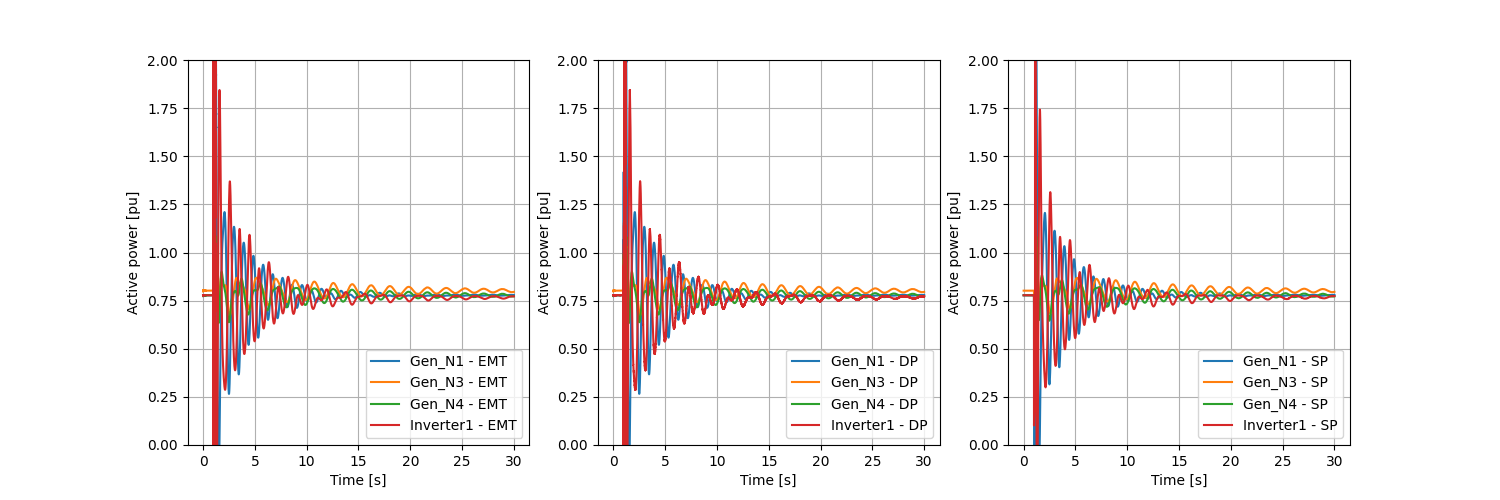

In [13]:
plot_varible(ts_dpsim_emt_1inverter, ts_dpsim_dp_1inverter, ts_dpsim_sp_1inverter, gen_list_1inverter, inverter_list_1inverter, "Pe", y_lim=[0., 2], x_lim=[], divider=900000000)

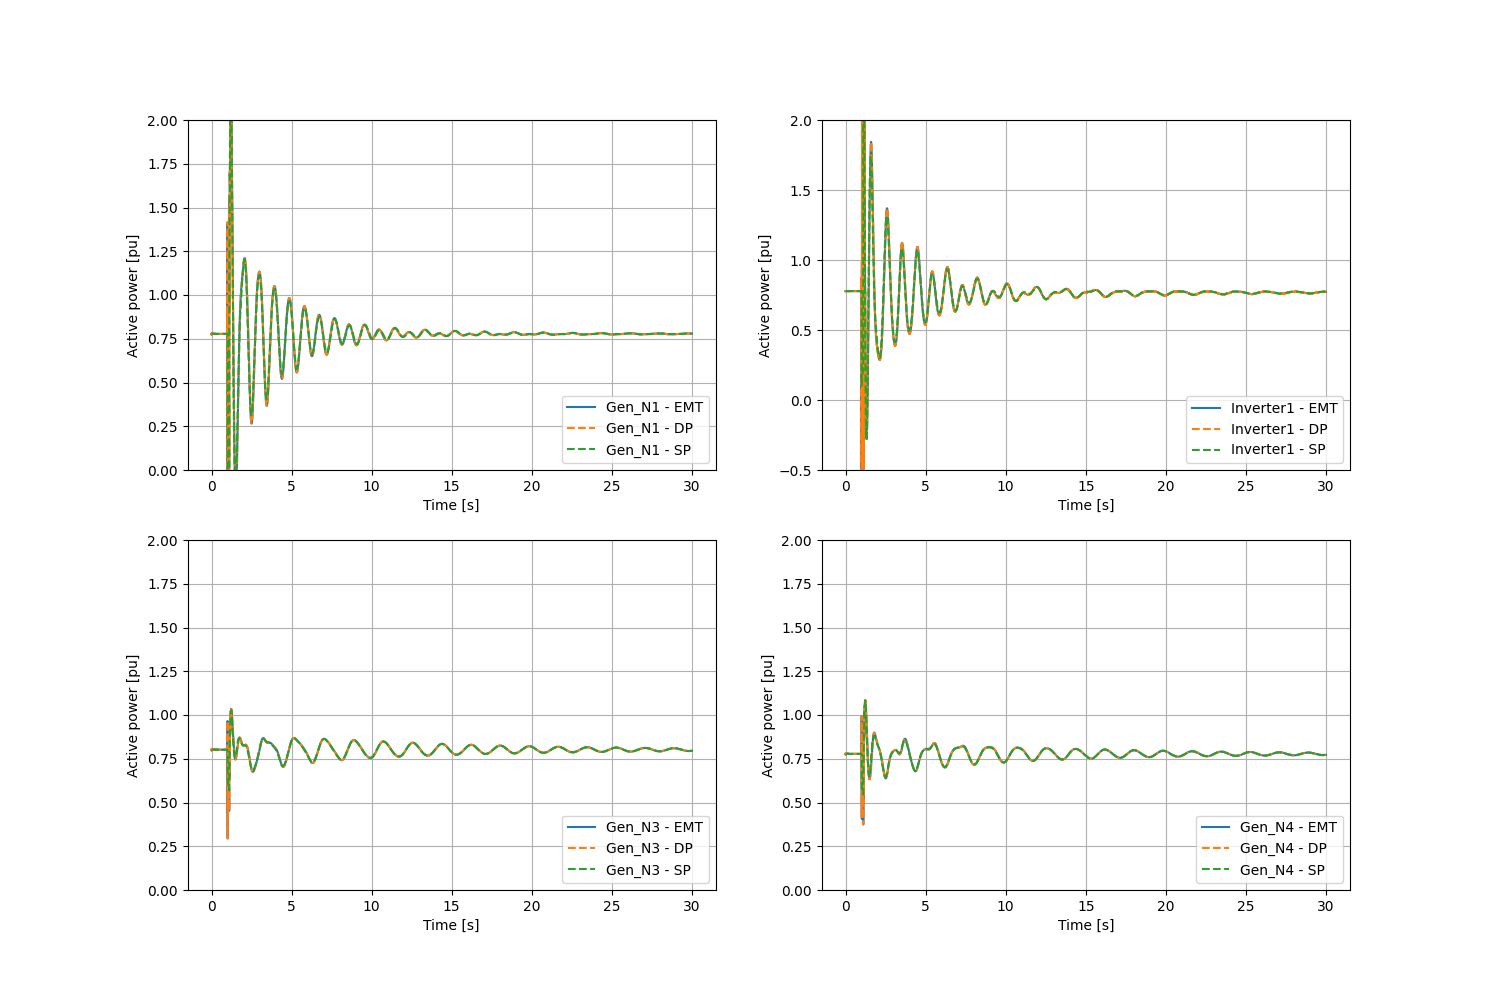

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

   
# Plot electrical power SG
gen_name = "Gen_N1"
axes[0][0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[0][0].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values, '--', label='{} - DP'.format(gen_name))
axes[0][0].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values, '--', label='{} - SP'.format(gen_name))
axes[0][0].legend(loc='lower right')
axes[0][0].set_xlabel('Time [s]')
axes[0][0].set_ylabel('Active power [pu]')
axes[0][0].set_ylim([0., 2.0])
axes[0][0].grid()

# Plot electricalInverter 1
gen_name = "Inverter1"
axes[0][1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values/900000000, label='{} - EMT'.format(gen_name))
axes[0][1].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values/900000000, '--', label='{} - DP'.format(gen_name))
axes[0][1].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values/900000000, '--', label='{} - SP'.format(gen_name))
axes[0][1].legend(loc='lower right')
axes[0][1].set_xlabel('Time [s]')
axes[0][1].set_ylabel('Active power [pu]')
axes[0][1].set_ylim([-0.5, 2.0])
#axes[0][1].set_xlim([0.98, 1.05])
axes[0][1].grid()

# Plot electrical power SG
gen_name = "Gen_N3"
axes[1][0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][0].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values, '--',  label='{} - DP'.format(gen_name))
axes[1][0].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values, '--', label='{} - SP'.format(gen_name))
axes[1][0].legend(loc='lower right')
axes[1][0].set_xlabel('Time [s]')
axes[1][0].set_ylabel('Active power [pu]')
axes[1][0].set_ylim([0., 2.0])
axes[1][0].grid()

# Plot electrical power SG
gen_name = "Gen_N4"
axes[1][1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][1].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values, '--', label='{} - DP'.format(gen_name))
axes[1][1].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values, '--', label='{} - SP'.format(gen_name))
axes[1][1].legend(loc='lower right')
axes[1][1].set_xlabel('Time [s]')
axes[1][1].set_ylabel('Active power [pu]')
axes[1][1].set_ylim([0., 2.0])
axes[1][1].grid()

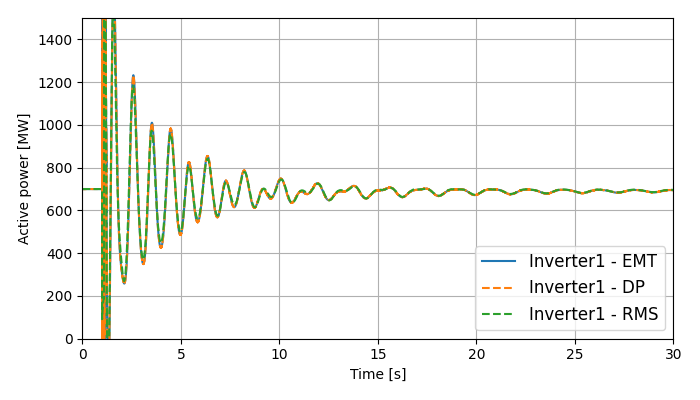

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

# Plot electricalInverter 1
gen_name = "Inverter1"
axes.plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values/1e6, label='{} - EMT'.format(gen_name))
axes.plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values/1e6, '--', label='{} - DP'.format(gen_name))
axes.plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values/1e6, '--', label='{} - RMS'.format(gen_name))
axes.legend(loc='lower right')
axes.set_xlabel('Time [s]')
axes.set_ylabel('Active power [MW]')
axes.set_ylim([0, 1500])
axes.set_xlim([0, 30])
axes.grid()

plt.tight_layout()
plt.savefig("./plotting/ActivePowerInverter_1Inverter.pdf")

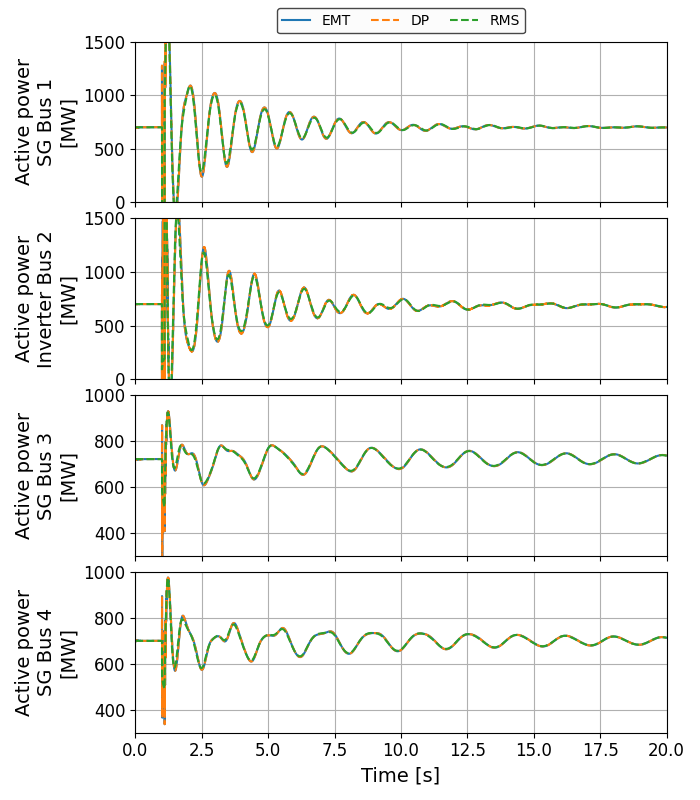

In [16]:
#fig = plt.figure(figsize=(7, 6))
#gs = fig.add_gridspec(4, 1, hspace=0.5)
#axes = gs.subplots(sharex=True, sharey=True)
#fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 6), sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 8), constrained_layout=False)
plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels

# Plot electricalInverter 1
gen_name = "Gen_N1"
label= "SG Bus 1"
axes[0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values*900, label='EMT')
axes[0].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values*900, '--', label='DP')
axes[0].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values*900, '--', label='RMS')
#axes[1].legend(loc='lower right')
#box = axes[0].get_position()
#print(box)
#axes[0].set_position([box.x0, box.y0, box.width, box.width*1.5])
#box = axes[0].get_position()
#print(box)
axes[0].legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', frameon = True, edgecolor='0.1', facecolor='0.99', ncol=3, columnspacing=1.5)
axes[0].set_ylim([0, 1500])
axes[0].set_xlim([0, 20])
axes[0].set_ylabel('Active power\nSG Bus 1\n[MW]')
axes[0].grid()
axes[0].label_outer()

# Plot electricalInverter 1
gen_name = "Inverter1"
axes[1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values/1e6, label='{} - EMT'.format(gen_name))
axes[1].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values/1e6, '--', label='{} - DP'.format(gen_name))
axes[1].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values/1e6, '--', label='{} - RMS'.format(gen_name))
#axes[0].legend(loc='lower right')
#axes[0].set_xlabel('Time [s]')
#axes[0].set_ylabel('Active power [MW]')
axes[1].set_ylim([0, 1500])
axes[1].set_xlim([0, 20])
axes[1].set_ylabel('Active power\nInverter Bus 2\n[MW]')
axes[1].grid()
axes[1].label_outer()


# Plot electricalInverter 1
gen_name = "Gen_N3"
axes[2].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values*900, label='{} - EMT'.format(gen_name))
axes[2].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values*900, '--', label='{} - DP'.format(gen_name))
axes[2].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values*900, '--', label='{} - RMS'.format(gen_name))
#axes[2].legend(loc='lower right')
#axes[2].set_xlabel('Time [s]')
#axes[2].set_ylabel('Active power [MW]')
axes[2].set_ylabel('Active power\nSG Bus 3\n[MW]')
axes[2].set_ylim([300, 1000])
axes[2].set_xlim([0, 20])
axes[2].grid()
axes[2].label_outer()

# Plot electricalInverter 1
gen_name = "Gen_N4"
axes[3].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values*900, label='{} - EMT'.format(gen_name))
axes[3].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values*900, '--', label='{} - DP'.format(gen_name))
axes[3].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values*900, '--', label='{} - RMS'.format(gen_name))
#axes[3].legend(loc='lower right', mode = "expand", ncol = 3)
axes[3].set_xlabel('Time [s]')
axes[3].set_ylabel('Active power\nSG Bus 4\n[MW]')
axes[3].set_ylim([300, 1000])
axes[3].set_xlim([0, 20])
axes[3].grid()
axes[3].label_outer()

labels = ["EMT", "DP", "SP"]
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels = [axes[1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc='lower right', mode = "expand", bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
#fig.legend(lines, labels, loc='upper right', mode = "expand", ncol=len(labels), bbox_to_anchor=(0.8,-.1))

plt.xlabel('Time [s]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)   
#fig.legend(lines, labels, mode = "expand", ncol = 3)
plt.savefig("./plotting/ActivePowerInverter_1Inverter.pdf")

In [17]:
"""
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

   
# Plot electrical power SG
gen_name = "Gen_N1"
axes[0][0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - DPsim'.format(gen_name))
axes[0][0].plot(ts_simulink['p1'].time, ts_simulink['p1'].values, '--', label='{} - Simulink'.format(gen_name))
axes[0][0].legend(loc='lower right')
axes[0][0].set_xlabel('Time [s]')
axes[0][0].set_ylabel('Active power [pu]')
axes[0][0].set_xlim([9.5, 30])
axes[0][0].set_ylim([0.25, 1.5])
axes[0][0].grid()

# Plot electricalInverter 1
gen_name = "Inverter1"
axes[0][1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values/900000000, label='{} - DPsim'.format(gen_name))
axes[0][1].plot(ts_simulink['p2'].time, ts_simulink['p2'].values, label='{} - Simulink'.format(gen_name))
axes[0][1].legend(loc='lower right')
axes[0][1].set_xlabel('Time [s]')
axes[0][1].set_ylabel('Active power [pu]')
axes[0][1].set_xlim([9.5, 30])
axes[0][1].set_ylim([0.25, 1.5])
#axes[0][1].set_xlim([0.98, 1.05])
axes[0][1].grid()

# Plot electrical power SG
gen_name = "Gen_N3"
axes[1][0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - DPsim'.format(gen_name))
axes[1][0].plot(ts_simulink['p3'].time, ts_simulink['p3'].values, label='{} - Simulink'.format(gen_name))
axes[1][0].legend(loc='lower right')
axes[1][0].set_xlabel('Time [s]')
axes[1][0].set_ylabel('Active power [pu]')
axes[1][0].set_xlim([9.5, 30])
axes[1][0].set_ylim([0.25, 1.25])
axes[1][0].grid()

# Plot electrical power SG
gen_name = "Gen_N4"
axes[1][1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - DPsim'.format(gen_name))
axes[1][1].plot(ts_simulink['p4'].time, ts_simulink['p4'].values, label='{} - Simulink'.format(gen_name))
axes[1][1].legend(loc='lower right')
axes[1][1].set_xlabel('Time [s]')
axes[1][1].set_ylabel('Active power [pu]')
axes[1][1].set_xlim([9.5, 30])
axes[1][1].set_ylim([0.25, 1.25])
axes[1][1].grid()
"""

'\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))\n\n   \n# Plot electrical power SG\ngen_name = "Gen_N1"\naxes[0][0].plot(ts_dpsim_emt_1inverter[\'{}.Pe\'.format(gen_name)].time, ts_dpsim_emt_1inverter[\'{}.Pe\'.format(gen_name)].values, label=\'{} - DPsim\'.format(gen_name))\naxes[0][0].plot(ts_simulink[\'p1\'].time, ts_simulink[\'p1\'].values, \'--\', label=\'{} - Simulink\'.format(gen_name))\naxes[0][0].legend(loc=\'lower right\')\naxes[0][0].set_xlabel(\'Time [s]\')\naxes[0][0].set_ylabel(\'Active power [pu]\')\naxes[0][0].set_xlim([9.5, 30])\naxes[0][0].set_ylim([0.25, 1.5])\naxes[0][0].grid()\n\n# Plot electricalInverter 1\ngen_name = "Inverter1"\naxes[0][1].plot(ts_dpsim_emt_1inverter[\'{}.Pe\'.format(gen_name)].time, ts_dpsim_emt_1inverter[\'{}.Pe\'.format(gen_name)].values/900000000, label=\'{} - DPsim\'.format(gen_name))\naxes[0][1].plot(ts_simulink[\'p2\'].time, ts_simulink[\'p2\'].values, label=\'{} - Simulink\'.format(gen_name))\naxes[0][1].legend(loc=\'lowe

### Omega

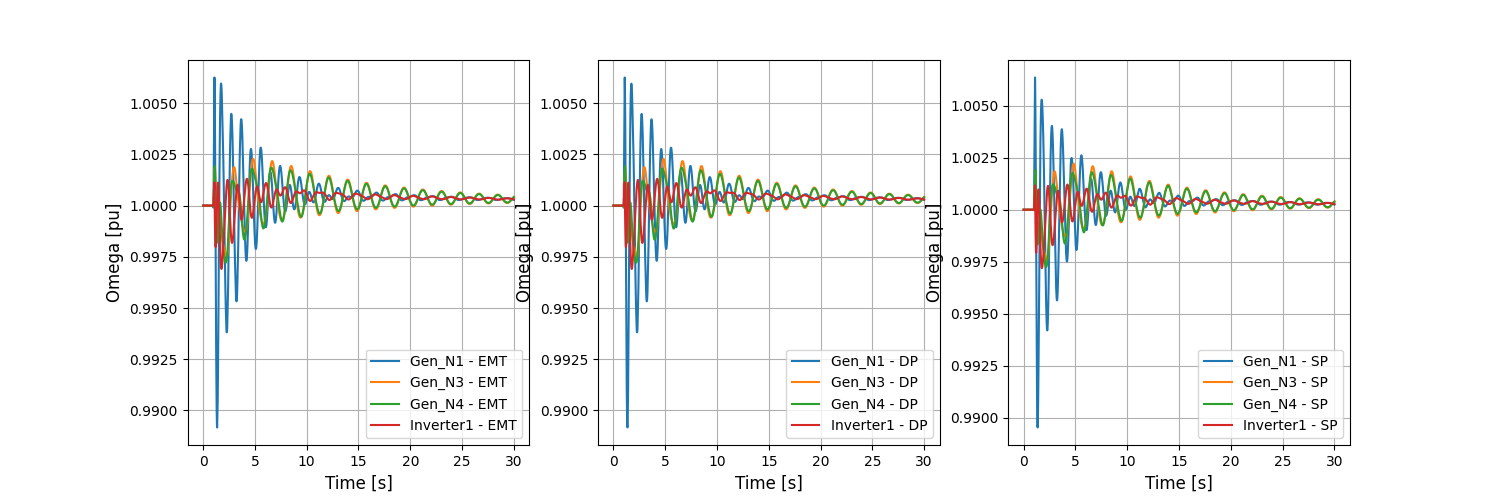

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot electrical power SG
for gen_name in gen_list_1inverter:
    axes[0].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
    axes[1].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
    axes[2].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
        
# Log electrical power Inverters
for idx, inverter in enumerate(inverter_list_1inverter):
    axes[0].plot(ts_dpsim_emt_1inverter['Inverter{}.w'.format(idx+1)].time, ts_dpsim_emt_1inverter['Inverter{}.w'.format(idx+1)].values/(2*np.pi*60), label='Inverter{} - EMT'.format(idx+1))
    axes[1].plot(ts_dpsim_dp_1inverter['Inverter{}.w'.format(idx+1)].time, ts_dpsim_dp_1inverter['Inverter{}.w'.format(idx+1)].values/(2*np.pi*60), label='Inverter{} - DP'.format(idx+1))
    axes[2].plot(ts_dpsim_sp_1inverter['Inverter{}.w'.format(idx+1)].time, ts_dpsim_sp_1inverter['Inverter{}.w'.format(idx+1)].values/(2*np.pi*60), label='Inverter{} - SP'.format(idx+1))

for ax in axes:
    ax.legend(loc='lower right')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Omega [pu]')
    #ax.set_ylim([0., 2])
    ax.grid()

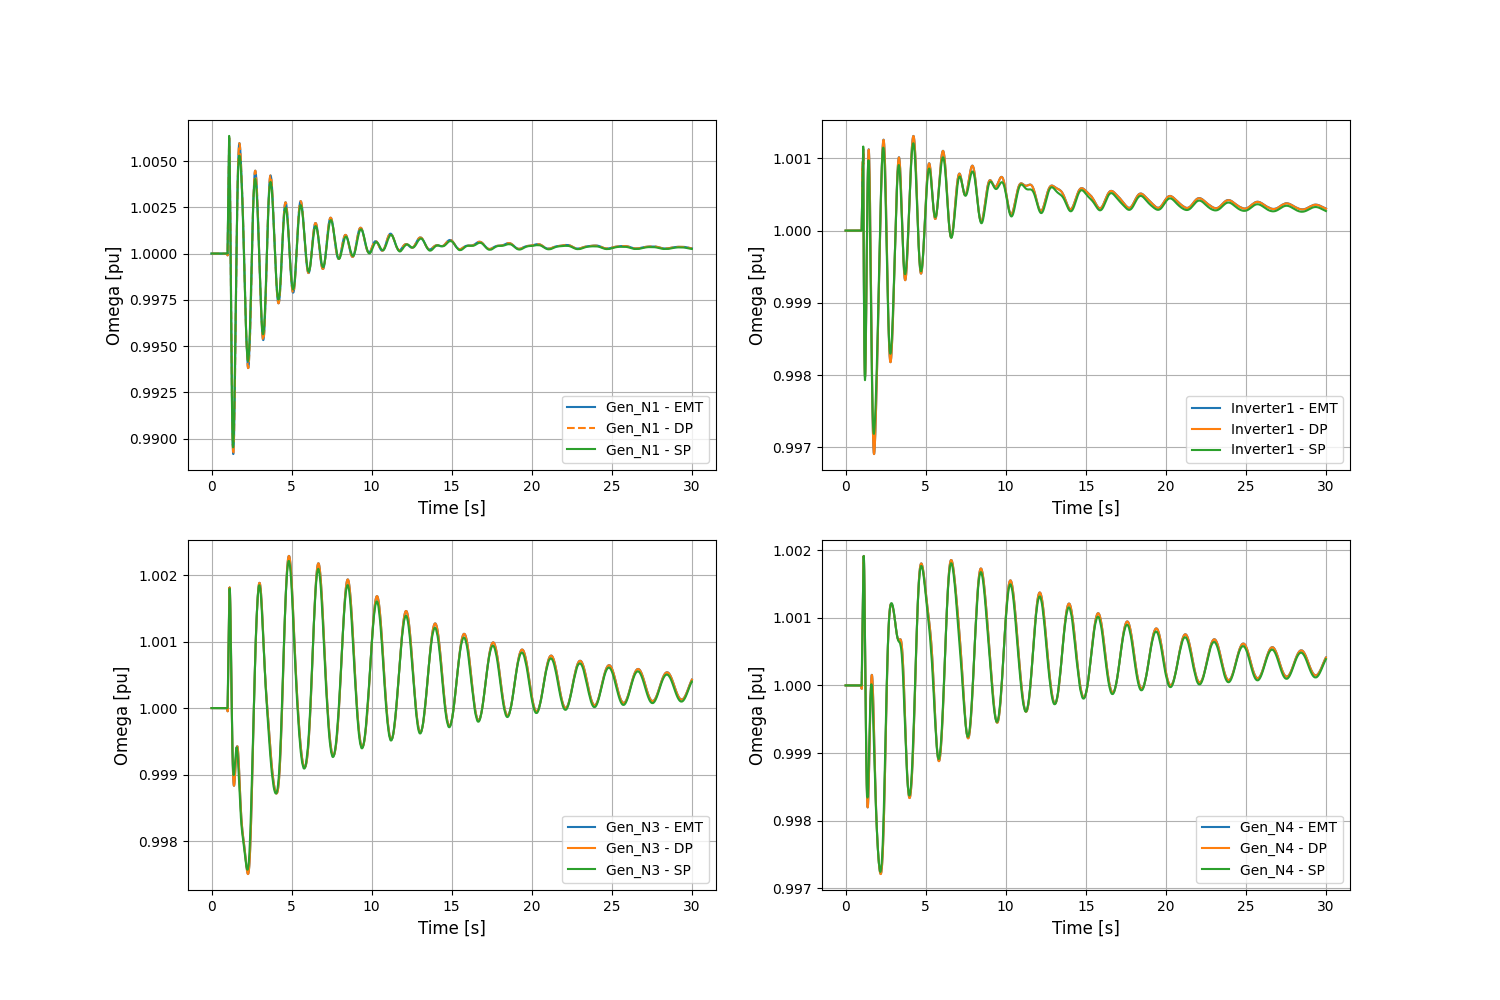

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

   
# Plot electrical power SG
gen_name = "Gen_N1"
axes[0][0].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[0][0].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, '--', label='{} - DP'.format(gen_name))
axes[0][0].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[0][0].legend(loc='lower right')
axes[0][0].set_xlabel('Time [s]')
axes[0][0].set_ylabel('Omega [pu]')
#axes[0][0].set_ylim([0., 2.0])
axes[0][0].grid()

# Plot electricalInverter 1
gen_name = "Inverter1"
axes[0][1].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values/(2*np.pi*60), label='{} - EMT'.format(gen_name))
axes[0][1].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values/(2*np.pi*60), label='{} - DP'.format(gen_name))
axes[0][1].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values/(2*np.pi*60), label='{} - SP'.format(gen_name))
axes[0][1].legend(loc='lower right')
axes[0][1].set_xlabel('Time [s]')
axes[0][1].set_ylabel('Omega [pu]')
#axes[0][1].set_ylim([-0.5, 2.0])
axes[0][1].grid()

# Plot electrical power SG
gen_name = "Gen_N3"
axes[1][0].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][0].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
axes[1][0].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[1][0].legend(loc='lower right')
axes[1][0].set_xlabel('Time [s]')
axes[1][0].set_ylabel('Omega [pu]')
#axes[1][0].set_ylim([0., 2.0])
axes[1][0].grid()

# Plot electrical power SG
gen_name = "Gen_N4"
axes[1][1].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][1].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
axes[1][1].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[1][1].legend(loc='lower right')
axes[1][1].set_xlabel('Time [s]')
axes[1][1].set_ylabel('Omega [pu]')
#axes[1][1].set_ylim([0., 2.0])
axes[1][1].grid()

#### Power exchange between Area 1 & Area 2

ValueError: x and y must have same first dimension, but have shapes (299990,) and (300000,)

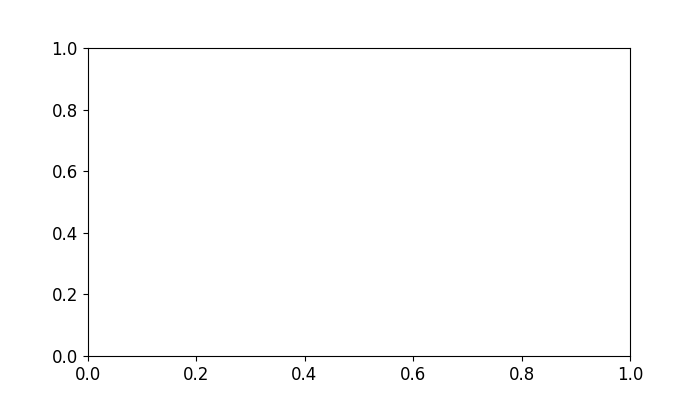

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
plt.rcParams.update({'font.size': 12})
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

timestep_common = 1e-4
t_begin = 0.0
t_end = 29.9
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = ts_dpsim_sp_1inverter["line3_7-8.I"].interpolate(timestep_common).time

### Calulate power exchange classical case
power_line3_sp = np.conjugate(ts_dpsim_sp_1inverter["line3_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_sp_1inverter["N7.V"].interpolate(timestep_common).values
power_line4_sp = np.conjugate(ts_dpsim_sp_1inverter["line4_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_sp_1inverter["N7.V"].interpolate(timestep_common).values
#power_switch_sp = np.conjugate(ts_dpsim_sp_1inverter["Switch.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_sp_1inverter["N8.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_sp = 0

power_line3_dp = np.conjugate(ts_dpsim_dp_1inverter["line3_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_dp_1inverter["N7.V"].interpolate(timestep_common).values
power_line4_dp = np.conjugate(ts_dpsim_dp_1inverter["line4_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_dp_1inverter["N7.V"].interpolate(timestep_common).values
#power_switch_dp = np.conjugate(ts_dpsim_dp_1inverter["Switch.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_dp_1inverter["N8.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_dp = 0

power_line3_emt = ts_dpsim_emt_1inverter["line3_7-8.I_0"].interpolate(timestep_common).values * ts_dpsim_emt_1inverter["N7.V_0"].interpolate(timestep_common).values + \
                  ts_dpsim_emt_1inverter["line3_7-8.I_1"].interpolate(timestep_common).values * ts_dpsim_emt_1inverter["N7.V_1"].interpolate(timestep_common).values + \
                  ts_dpsim_emt_1inverter["line3_7-8.I_2"].interpolate(timestep_common).values * ts_dpsim_emt_1inverter["N7.V_2"].interpolate(timestep_common).values
power_line4_emt = ts_dpsim_emt_1inverter["line4_7-8.I_0"].interpolate(timestep_common).values * ts_dpsim_emt_1inverter["N7.V_0"].interpolate(timestep_common).values + \
                  ts_dpsim_emt_1inverter["line4_7-8.I_1"].interpolate(timestep_common).values * ts_dpsim_emt_1inverter["N7.V_1"].interpolate(timestep_common).values + \
                  ts_dpsim_emt_1inverter["line4_7-8.I_2"].interpolate(timestep_common).values * ts_dpsim_emt_1inverter["N7.V_2"].interpolate(timestep_common).values       
#power_switch_emt = ts_dpsim_emt_1inverter["Switch.I_0"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N8.V_0"].interpolate(timestep_common).values[begin_idx:end_idx] + \
#                   ts_dpsim_emt_1inverter["Switch.I_1"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N8.V_1"].interpolate(timestep_common).values[begin_idx:end_idx] + \
#                   ts_dpsim_emt_1inverter["Switch.I_2"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N8.V_2"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_emt = 0

#fig, ax1 = plt.subplots(figsize=(7, 4))
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
axes.plot(time, (power_line3_emt + power_line4_emt - power_switch_emt) * 1e-6, label='EMT')
axes.plot(time, (power_line3_dp + power_line4_dp - power_switch_dp).real * 1e-6, '--', label='DP')
axes.plot(time, (power_line3_sp + power_line4_sp - power_switch_sp).real  * 1e-6, '--', label='RMS')
axes.legend(loc='lower right')
axes.set_xlabel('Time [s]')
axes.set_ylabel('Active power exchange \nArea 1 - Area 2 [MW]')
axes.grid()
axes.set_xlim([0, 30])
axes.set_ylim([200, 600])
#axes[0].axvline(x=8.28849219, color = 'r', linestyle = '-')
#axes[0].axvline(x=10.3410821, color = 'r', linestyle = '-')

t_begin = 1.5
t_end = 1.7
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
np.amax((power_line3_emt + power_line4_emt)[begin_idx:end_idx])
pos = (power_line3_emt + power_line4_emt)[begin_idx:end_idx].argmax()
time1 = (time[begin_idx:end_idx])[pos]

t_begin = 1.84
t_end = 2.17
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
np.amax((power_line3_emt + power_line4_emt)[begin_idx:end_idx])
pos = (power_line3_emt + power_line4_emt)[begin_idx:end_idx].argmax()
time2 = (time[begin_idx:end_idx])[pos]

#axes.axvline(x=time1, color = 'r', linestyle = '--')
#axes.axvline(x=time2, color = 'r', linestyle = '--')
print(time2-time1)
print(1/(time2-time1))


t_begin = 1.5
t_end = 1.7
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
np.amax((power_line3_emt + power_line4_emt)[begin_idx:end_idx])
pos = (power_line3_emt + power_line4_emt)[begin_idx:end_idx].argmax()
time1 = (time[begin_idx:end_idx])[pos]

t_begin = 2.5
t_end = 2.8
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
np.amax((power_line3_emt + power_line4_emt)[begin_idx:end_idx])
pos = (power_line3_emt + power_line4_emt)[begin_idx:end_idx].argmax()
time2 = (time[begin_idx:end_idx])[pos]

#axes.axvline(x=time1, color = 'b', linestyle = '--')
#axes.axvline(x=time2, color = 'b', linestyle = '--')
print(time2-time1)
print(1/(time2-time1))

t_begin = 2.5
t_end = 2.8
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
np.amax((power_line3_emt + power_line4_emt)[begin_idx:end_idx])
pos = (power_line3_emt + power_line4_emt)[begin_idx:end_idx].argmax()
time1 = (time[begin_idx:end_idx])[pos]

t_begin = 4
t_end = 5
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
np.amax((power_line3_emt + power_line4_emt)[begin_idx:end_idx])
pos = (power_line3_emt + power_line4_emt)[begin_idx:end_idx].argmax()
time2 = (time[begin_idx:end_idx])[pos]

#axes.axvline(x=time1, color = 'r', linestyle = '--')
#axes.axvline(x=time2, color = 'r', linestyle = '--')
print(time2-time1)
print(1/(time2-time1))

plt.tight_layout()
plt.savefig("./plotting/PowerExchange_OneInverter.pdf")

In [ ]:
timestep_common = 5e-5
t_begin = 10
t_end = 30
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
   
Fs = int(1 / timestep_common)
# emt
axes[0].magnitude_spectrum((power_line3_emt + power_line4_emt)[begin_idx:end_idx], Fs=Fs, label='Tie Line Power - EMT', sides='twosided', scale='dB', window=plt.mlab.window_none)
axes[0].magnitude_spectrum((power_line3_dp + power_line4_dp)[begin_idx:end_idx], Fs=Fs, label='Tie Line Power - DP', sides='twosided', scale='dB', window=plt.mlab.window_none)
axes[0].magnitude_spectrum((power_line3_sp + power_line4_sp)[begin_idx:end_idx], linestyle='--', Fs=Fs, label='Tie Line Power - RMS', sides='twosided', scale='dB', window=plt.mlab.window_none)
#axes[0].axvline(x=0.55, color = 'r', linestyle = '--')
axes[0].set_xlim(-10,10)
axes[0].set_ylim(80,200)
axes[0].legend()
axes[0].grid()

axes[1].magnitude_spectrum((power_line3_sp + power_line4_sp), Fs=Fs, label='Tie Line Power - RMS', sides='twosided')
axes[1].axvline(x=0.55, color = 'r', linestyle = '--')
axes[1].set_xlim(-2,2)
axes[1].legend()
axes[1].grid()

In [ ]:
test = TimeSeries(name="power", time=ts_dpsim_emt_1inverter["line3_7-8.I_0"].time, values=power_line3_emt)
test.calc_freq_spectrum() # return: fft_freqs[:freqs_num], np.abs(fft_values[:freqs_num])/freqs_num

In [ ]:
Ts = 5e-5
fft_values = np.abs(np.fft.rfft(power_line3_emt, norm='ortho')/Ts)
freqs_num = int(len(fft_values)/2)
fft_freqs = np.fft.rfftfreq(len(fft_values), d=Ts)

plt.figure()
plt.plot(np.abs(fft_values[:freqs_num])/freqs_num)
plt.xlim([0,2.5])
